In [1]:
#MIT License 
author Mark Higgins

In [2]:
from netCDF4 import Dataset,num2date
from siphon import catalog, ncss
import datetime
import xarray as xr # I can't get xarray to work 

In [3]:
url="http://psdc.163.165.212.227.xip.io/thredds/catalog.xml"
tds=catalog.TDSCatalog(url)

In [4]:
# catalog_refs contains the list of all the avaliable parameters 
# also check what is at a second level down - this may be the wrong way to do this ...!
for this_param in tds.catalog_refs:
    this_data_entry = catalog.TDSCatalog(tds.catalog_refs[this_param].href)
    try:
        if len(this_data_entry.datasets[this_param].access_urls) == 0:
            print("level=2 ",this_data_entry.datasets,
                  catalog.TDSCatalog(tds.catalog_refs[this_param].href).catalog_refs)
        else:
            print("level=1 ",this_data_entry.datasets) # print the data sets available
    except:
        print("No references",this_param)
        pass

level=2  ['CMSAF_CDR_DNI_M'] ['CMSAF_CDR_DNI_M_rnsds', 'CMSAF_CDR_DNI_M_rnsdscs']
level=2  ['CMSAF_CDR_DNI_D'] ['CMSAF_CDR_DNI_D_rnsds', 'CMSAF_CDR_DNI_D_rnsdscs']
level=1  ['CMSAF_CDR_SDU_M']
level=1  ['CMSAF_CDR_SDU_D']
level=2  ['CMSAF_CDR_SIS_M'] ['CMSAF_CDR_SIS_M_rsds', 'CMSAF_CDR_SIS_M_rsdscs']
level=2  ['CMSAF_CDR_SIS_D'] ['CMSAF_CDR_SIS_D_rsds', 'CMSAF_CDR_SIS_D_rsdscs']
level=2  ['CMSAF_ICDR_DNI_M'] ['CMSAF_ICDR_DNI_M_rnsds', 'CMSAF_ICDR_DNI_M_rnsdscs']
level=2  ['CMSAF_ICDR_DNI_D'] ['CMSAF_ICDR_DNI_D_rnsds', 'CMSAF_ICDR_DNI_D_rnsdscs']
level=1  ['CMSAF_ICDR_SDU_M']
level=1  ['CMSAF_ICDR_SDU_D']
level=2  ['CMSAF_ICDR_SIS_M'] ['CMSAF_ICDR_SIS_M_rsds', 'CMSAF_ICDR_SIS_M_rsdscs']
level=2  ['CMSAF_ICDR_SIS_D'] ['CMSAF_ICDR_SIS_D_rsds', 'CMSAF_ICDR_SIS_D_rsdscs']
level=1  ['ECMWF_T2M_M']
level=1  ['GPCC_PRECIP_M']
level=2  ['HSAF_CDR_WET_D'] ['HSAF_CDR_WET_D_swi1', 'HSAF_CDR_WET_D_swi2', 'HSAF_CDR_WET_D_swi3', 'HSAF_CDR_WET_D_swi4']
level=2  ['HSAF_ICDR_WET_D'] ['HSAF_ICDR_WET_D_sw

In [5]:
# manual entry by user of what they want 
level=2
my_level1_param="CMSAF_CDR_DNI_M"
my_level2_param="CMSAF_CDR_DNI_M_rnsds"
if level==1:
    my_param=my_level1_param
    my_data_entry = catalog.TDSCatalog(tds.catalog_refs[my_param].href)
    print(catalog.TDSCatalog(tds.catalog_refs[my_param].href).catalog_refs) # should match what you ask for
if level==2:
    my_param = my_level2_param
    level1_entry= catalog.TDSCatalog(tds.catalog_refs[my_level1_param].href)
    my_data_entry=catalog.TDSCatalog(level1_entry.catalog_refs[my_param].href)
    print(catalog.TDSCatalog(level1_entry.catalog_refs[my_level2_param].href).catalog_refs)  # should match

['CMSAF_CDR_DNI_M_rnsds']


In [ ]:
# read the data into xarray
#THIS DOES NOT ?YET? WORK
#data_set = my_data_entry.datasets[my_param].remote_access(use_xarray=True)

In [6]:
ncss=my_data_entry.datasets[my_param].subset() # get a subset object 

In [7]:
print(ncss.variables) # list the variables

{'rnsds'}


In [8]:
time_span = ncss.metadata.time_span
lat_lon_box = ncss.metadata.lat_lon_box
ntimes = ncss.metadata.axes["time"]

In [9]:
first_variable=list(ncss.variables)[0] # get first vaiable in list 
my_var=first_variable   # assume the first one is interesting and use this one ... 
                        #You probably want to make an actual choice here :) 
#my_var="tp"

In [10]:
#set up a data access request'
query = ncss.query() # set up a blank query
query.variables(my_var) # set a variable to request

var=rnsds

In [11]:
years=30 # years can be ok for monthly data - for hourly data may want something shorter
now = datetime.datetime.utcnow()
query.time_range(now - datetime.timedelta(weeks=years*52),now) 
# timedelta has no years due to leap years - so count back in weeks ... 


var=rnsds&time_start=1991-05-31T09%3A44%3A28.997664&time_end=2021-04-23T09%3A44%3A28.997664

In [12]:
# now get the data
data = ncss.get_data(query)

In [13]:
data[my_var]

<class 'netCDF4._netCDF4.Variable'>
float32 rnsds(time, lat, lon)
    _FillValue: nan
    units: W m-2
    tentative_standard_name: surface_normalized_direct_shortwave_flux_in_air
    long_name: surface normalized direct shortwave flux
    grid_mapping: crs
    _ChunkSizes: [   1    1 1200]
    coordinates: time lat lon 
unlimited dimensions: 
current shape = (319, 500, 1200)
filling on

In [14]:
lons = data.variables['lon'][:] # get lons
lats = data.variables['lat'][:] # get lats

In [15]:
# get list of dates 8conversted from ncdf format to datetime)
dates=num2date(data.variables['time'],data.variables['time'].units)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


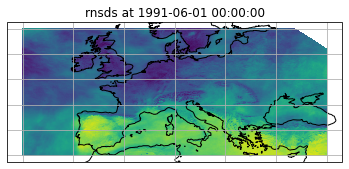

In [16]:
# simple plot 
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, data.variables[my_var][0, :, :],
             transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.title(my_var+" at "+dates[0].strftime())
plt.show()

In [17]:
# simple plot driven by widget 
from IPython.display import display
import ipywidgets as widgets
import cartopy.crs as ccrs

def plot(timeidx=0, colormap=''):
    try:
        ax.clear()
    except:
        pass
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_title(my_var+" at "+dates[timeidx].strftime(), size=16)
    ax.coastlines()
    ax.gridlines()
    ax.pcolormesh(lons, lats, data.variables[my_var][timeidx,:,:],
             transform=ccrs.PlateCarree(),cmap=colormap)

    
time_widget = widgets.IntSlider(description='Time',min=0,max=len(dates)-1,step=1,readout=False,width='80%')
colormap_widget = widgets.ToggleButtons(description='Colormap',
                                       options=['viridis', 'coolwarm', 'YlGnBu', 'RdPu'])

x = widgets.interactive(plot, timeidx=time_widget, colormap=colormap_widget)
display(x)


interactive(children=(IntSlider(value=0, description='Time', max=318, readout=False), ToggleButtons(descriptio…